In [105]:
import tensorflow as tf
import os
import random
import numpy as np


In [106]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

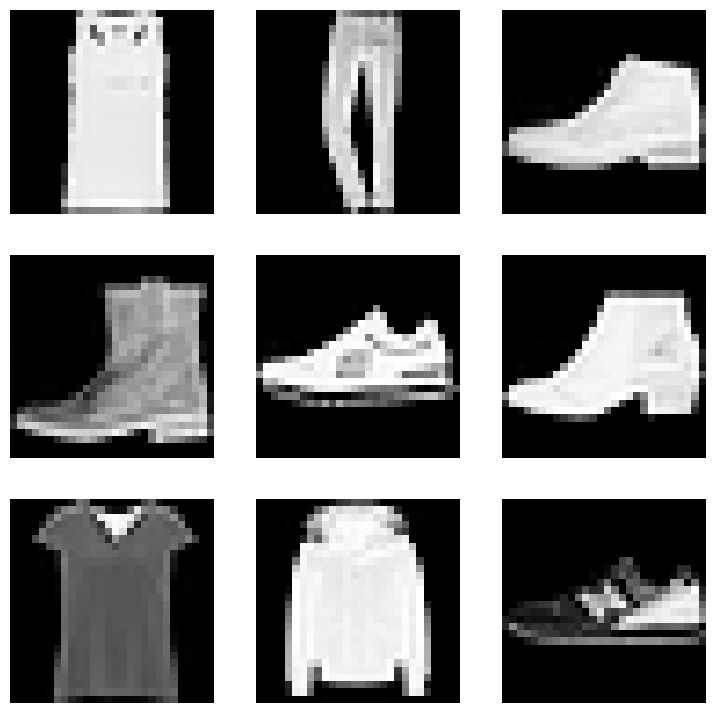

In [107]:
#verificando algumas imagens
from matplotlib import pyplot as plt
plt.figure(figsize = (9, 9))
rndSamples = np.random.choice(60000,9)

for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(x_train[rndSamples[i]], cmap = "Greys_r")
  plt.axis('off')

plt.show();

In [108]:
#concatenando os dados de teste e treinamento
# *redes generativas não precisam de datasets de teste
dataset = np.concatenate([x_train, x_test], axis=0)
#add 1 canal  de cor para acertar a dimensionalidade
dataset = np.expand_dims(dataset,-1).astype("float32")/355

In [109]:
from tensorflow import keras
from tensorflow.keras import layers

#Adicionando camada de amostragem
class SamplingLayer(layers.Layer):

  def call(self, inputs):
    zMean, zLogvar = inputs
    batch = tf.shape(zMean)[0]
    dim = tf.shape(zMean)[1]
    epsilon = tf.keras.backend.random_normal(shape = (batch, dim))
    return zMean + tf.exp(0.5 * zLogVar) * epsilon

## Criando Encoder




In [110]:

from tensorflow.keras import Layer
from tensorflow import keras

class SamplingLayer(Layer):
  def call(self, inputs):
    zMean, zLogVar = inputs
    batch = tf.shape(zMean)[0]
    dim = tf.shape(zMean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return zMean + tf.exp(0.5 * zLogVar) * epsilon


from keras import Model, Input
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout

def buildEncoder(latentDim, encoderInputs):
    l1 = Sequential([
        Conv2D(128, 3, activation='relu', strides=2, padding='same'),
        Dropout(0.3),
        Conv2D(64, 3, activation='relu', strides=2, padding='same'),
        Dropout(0.3),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.3)
    ])# cria o encoder com duas camadas de convolução para extra~çao de características e uma camada densa com 256 nodos para transformá-las em um vetor

    x = l1(encoderInputs)

    zMean = Dense(latentDim, name='z_mean')(x)
    zLogVar = Dense(latentDim, name='z_log_var')(x)
    z = SamplingLayer()([zMean, zLogVar])#váriaveis necessárias para disponibilizar o vetor latente em uma distribuição probabilística

    return Model(encoderInputs, [zMean, zLogVar, z], name='encoder')

encoderInputs = Input(shape=(28, 28, 1))
encoder = buildEncoder(2, encoderInputs)
encoder.summary()



Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, 256)            │        878,144 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            514 │ sequential_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            514 │ sequential_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_layer_2          │ (None, 2)              │              0 │ z_mean[0][0],          │
│ (SamplingLayer)           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 879,172 (3.35 MB)

 Trainable params: 879,172 (3.35 MB)

 Non-trainable params: 0 (0.00 B)

**Implementando o decoder**

In [111]:
def buildDecoder(latentInputs):
  l1 = keras.models.Sequential([
      layers.Dense(7*7*64, activation="relu", input_shape=(latentInputs.shape[1],)),
      layers.Reshape((7,7,64)),
      layers.Conv2DTranspose(128,3,activation="relu", strides=2, padding="same"),
      layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"),
      layers.Conv2DTranspose(1, 3, activation = "sigmoid", padding="same")
  ])
  return keras.Model(latentInputs, l1(latentInputs), name="decoder")

latentInputs = keras.Input(shape=(2,))
decoder = buildDecoder(latentInputs)
decoder.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_5 (Sequential)            │ (None, 28, 28, 1)           │         157,633 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 157,633 (615.75 KB)

 Trainable params: 157,633 (615.75 KB)

 Non-trainable params: 0 (0.00 B)

### Funções de perda

In [112]:
#função que penaliza reconstruções não similares às imagens originais
def reconstructionLoss(data, reconstructed):
  return tf.reduce_mean(
      tf.reduce_sum(
          keras.losses.binary_crossentropy(data, reconstructed),
          axis=(1,2)
      )
  )

In [113]:
#calcula a distância entre as distribuições de probabilidades entre entrada e saída
def KlDivergenceLoss(zMean, zLogVar):
  return tf.reduce_mean(
      tf.reduce_sum(
          -0.5*(1 + zLogVar - tf.square(zMean)-tf.exp(zLogVar)),
          axis=1
      )
  )

In [114]:
#calcula a perda total em função das duas funções de perda
def calcTotalLoss(data, reconstructed, zMean, zLogVar):
  loss1 = reconstructionLoss(data, reconstructed)
  loss2 = KlDivergenceLoss(zMean,zLogVar)
  klweight = 3.0
  return loss1, loss2, loss1 + klweight*loss2

In [115]:
class  VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
  #registra  a perda total como uma métrica no histórico
    self.totalLossTracker = keras.metrics.Mean(name = "total_loss")
    self.ceLossTracker = keras.metrics.Mean(name = "ce_loss")
    self.klLossTracker = keras.metrics.Mean(name = "kl_loss")

  @property
  def metrics(self):
    return [
        self.totalLossTracker,
        self.ceLossTracker,
        self.klLossTracker
    ]

#função que calcula perda, os gradientes, e atualiza os pesos
  def train_step(self, data):
    with tf.GradientTape() as tape:
      zMean, zLogVar, z = self.encoder(data)
      reconstruction = self.decoder(z)
      ceLoss, klLoss, totalLoss = calcTotalLoss(data, reconstruction, zMean, zLogVar)

    grads = tape.gradient(totalLoss, self.trainable_weights) # calcula o gradiente
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    self.totalLossTracker.update_state(totalLoss)
    self.ceLossTracker.update_state(ceLoss)
    self.klLossTracker.update_state(klLoss)

    return {
        "total_loss": self.totalLossTracker.result(),
        "ce_loss": self.ceLossTracker.result(),
        "kl_loss": self.klLossTracker.result()
    }




#treinando o vae

In [116]:
vae = VAE(encoder, decoder)
vae.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.01))
history = vae.fit(dataset, epochs = 32, batch_size = 128)

Epoch 1/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - ce_loss: 320.6793 - kl_loss: 2.1854 - total_loss: 327.2355
Epoch 2/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - ce_loss: 272.0562 - kl_loss: 3.9013 - total_loss: 283.7601
Epoch 3/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - ce_loss: 269.9559 - kl_loss: 4.0047 - total_loss: 281.9702
Epoch 4/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - ce_loss: 267.6658 - kl_loss: 4.0909 - total_loss: 279.9386
Epoch 5/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - ce_loss: 266.9159 - kl_loss: 4.1378 - total_loss: 279.3293
Epoch 6/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - ce_loss: 266.3429 - kl_loss: 4.2085 - total_loss: 278.9685
Epoch 7/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - ce_loss: 265.2550 - kl_loss: 4.2092 - total_loss: 277.8828
Epoch 8/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - ce_loss: 265.7155 - kl_loss: 4.2254 - total_loss: 278.3916
Epoch 9/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - ce_loss: 266.0097 - kl_loss

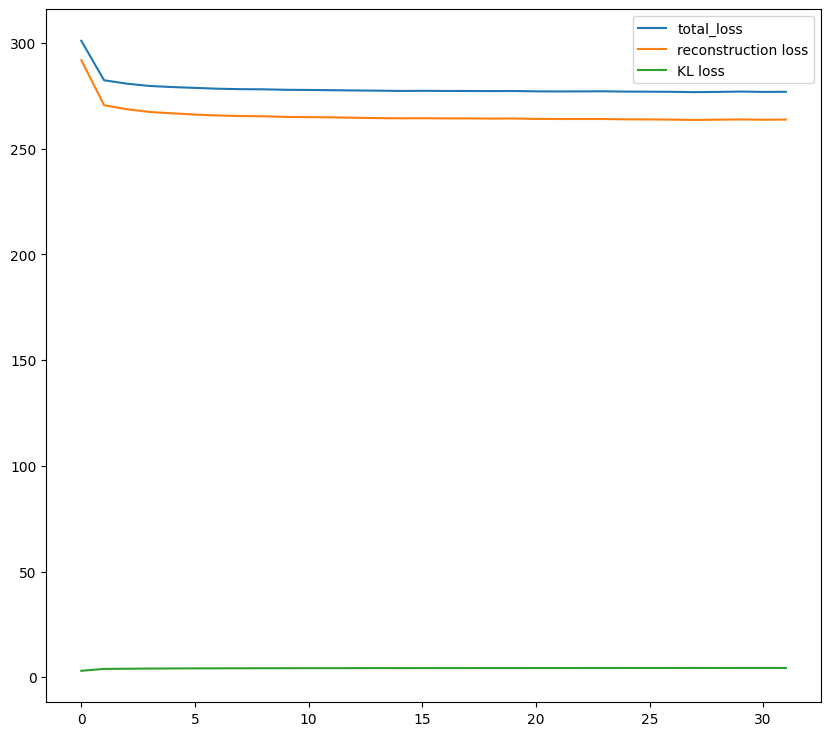

In [117]:
#visualizando a função de perda ao longo das épocas
plt.figure(figsize=(10,9))
plt.plot(history.history.get('total_loss'), label = "total_loss")
plt.plot(history.history.get('ce_loss'), label="reconstruction loss")
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

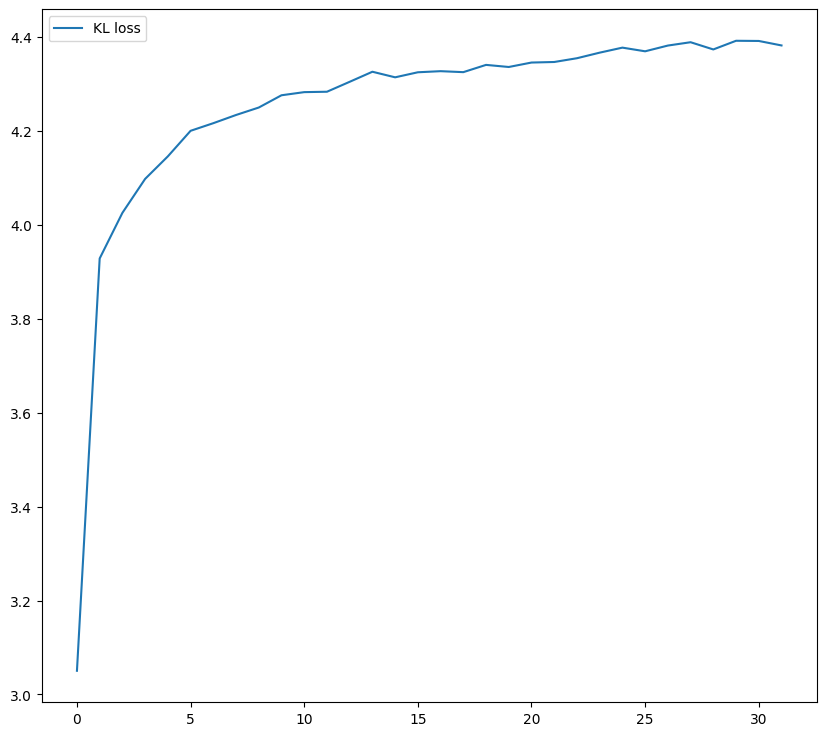

In [118]:
plt.figure(figsize=(10,9))
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

#testando os resultados

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


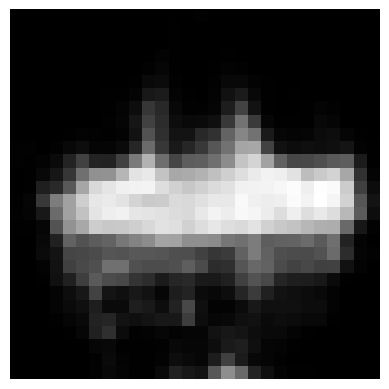

In [122]:

synth = vae.decoder.predict(np.array([[3,1]]))
plt.axis('off')
plt.imshow(synth.reshape((28,28)), cmap="Greys_r");

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


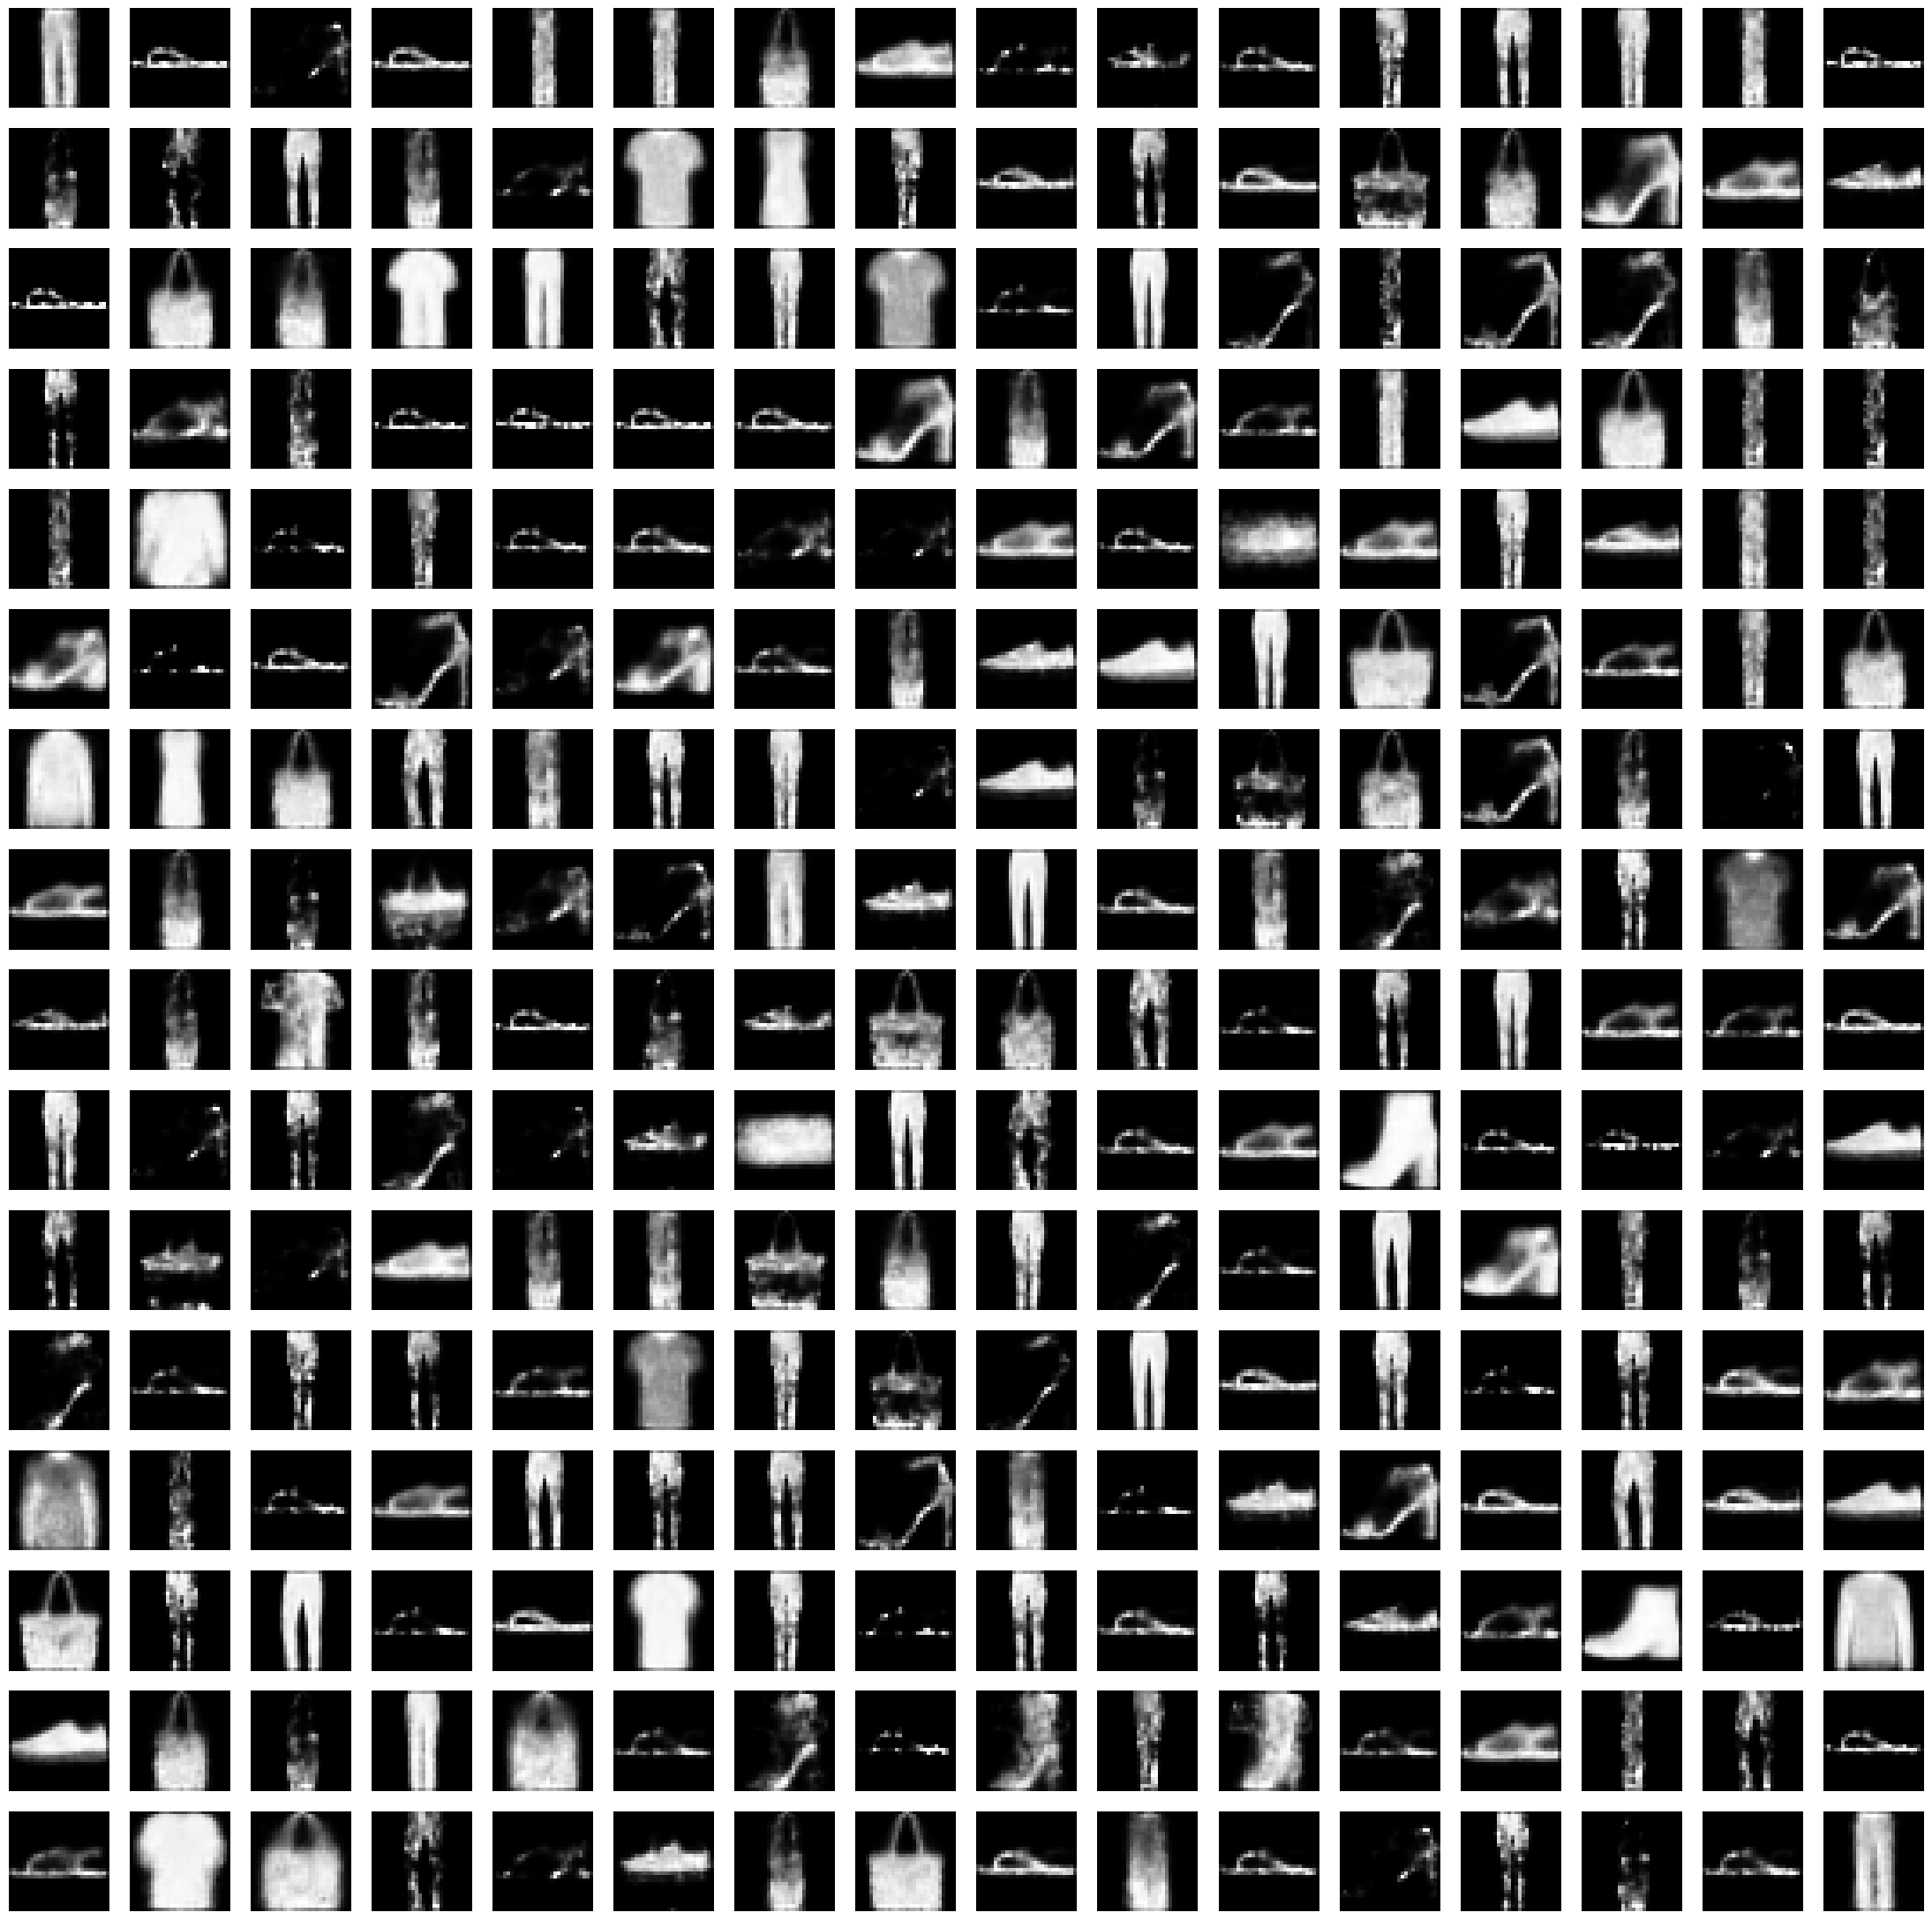

In [123]:
# gerando 256 imagens aleatórias:
z = np.random.normal(loc=0, scale=4, size=(256,2))
synth = vae.decoder.predict(z)

plt.figure(figsize = (28,28))

for i in range(256):
  plt.subplot(16,16, i+1)
  plt.imshow(synth[i].reshape(28,28), cmap = "Greys_r")
  plt.axis('off')

plt.show();

In [124]:
# encontrando os valores otimizados para MU e e sigma para cada categoria.
idx = 1260
batch = np.expand_dims(x_train[idx], axis = 0)
batchofimages = np.expand_dims(batch, axis = -1).astype("float32")/255
print(batchofimages.shape)

_, _, z = vae.encoder.predict(batchofimages)

synth = vae.decoder.predict([z])

z




(1, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


array([[ 1.0379615, -0.2877805]], dtype=float32)

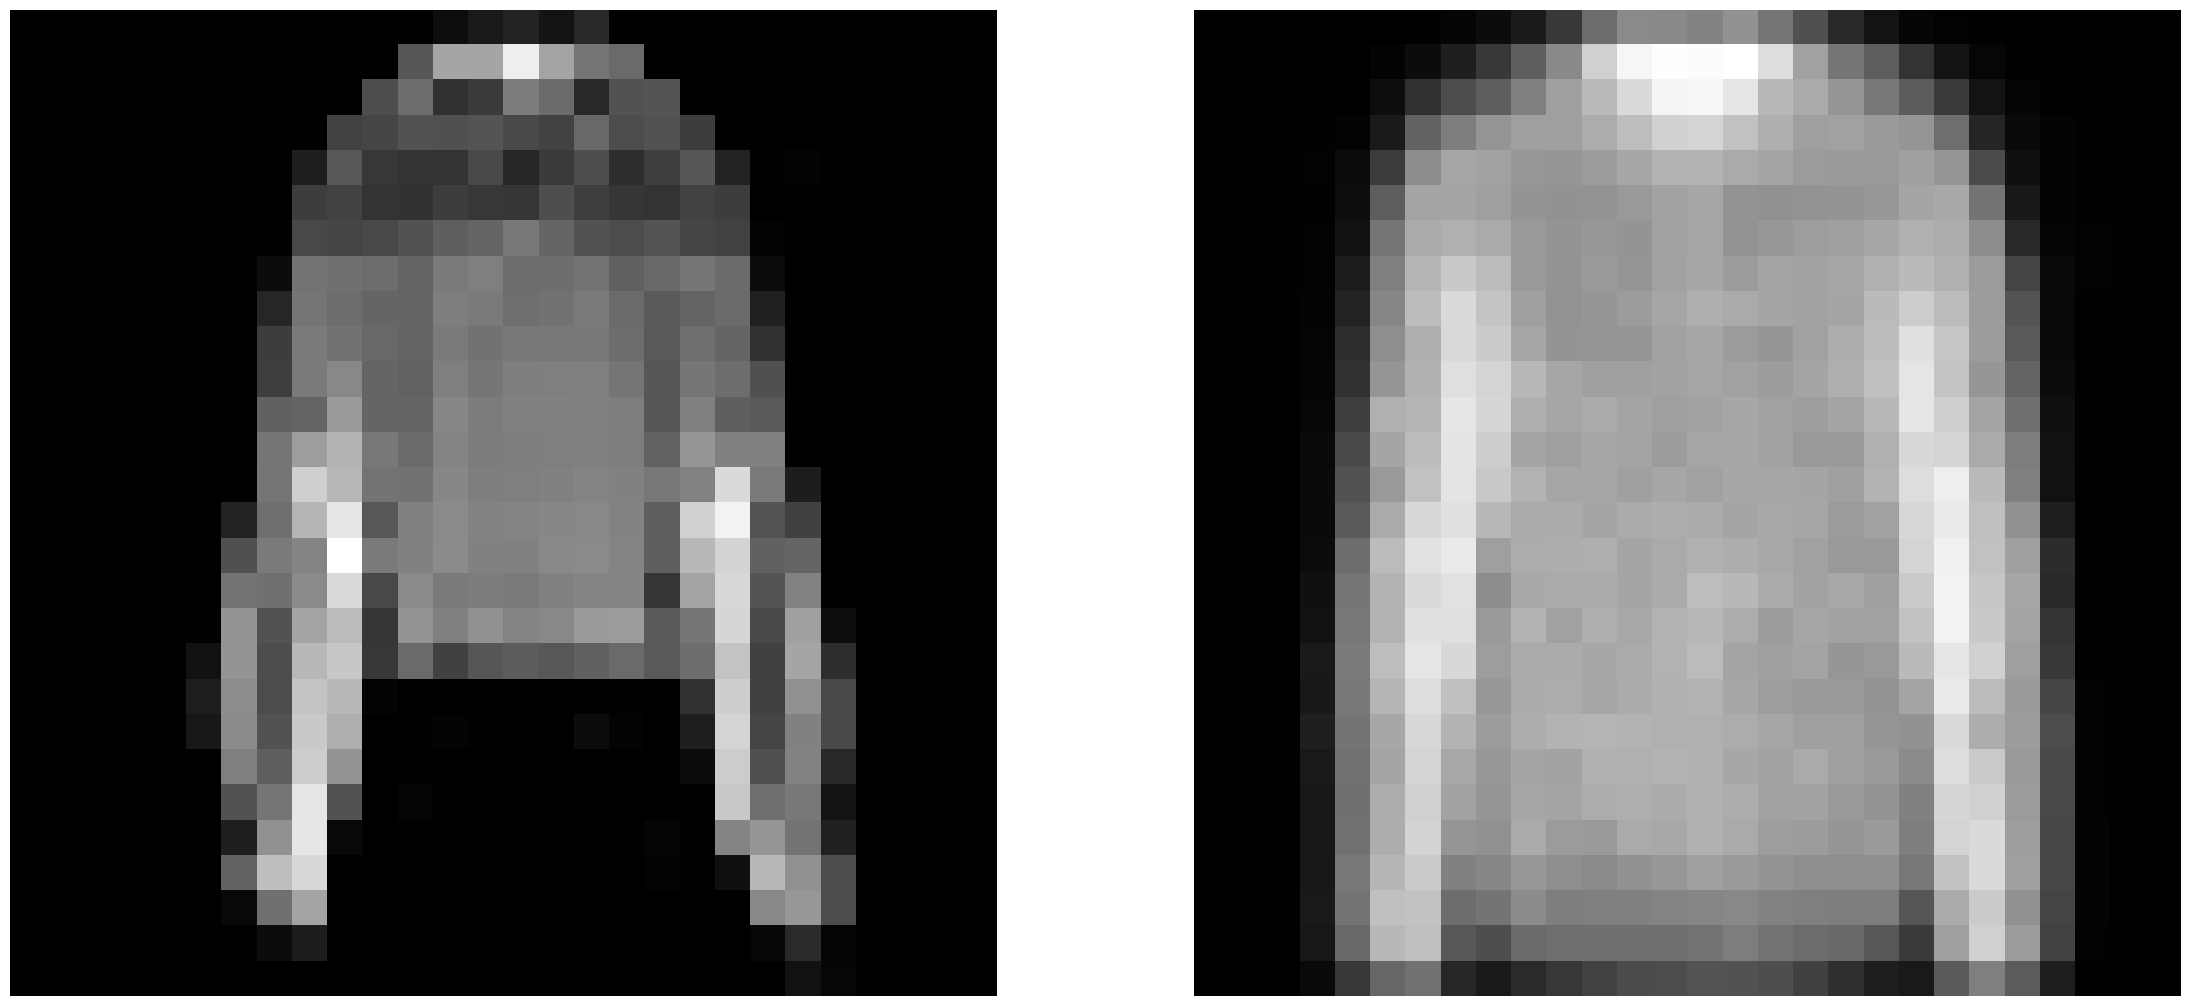

In [125]:
plt.figure(figsize=(28,28))

#imagem original
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(x_train[idx], cmap = "Greys_r")

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(synth[0].reshape((28,28)), cmap = "Greys_r")
plt.show();

2188/2188 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


NameError: name 'ptl' is not defined

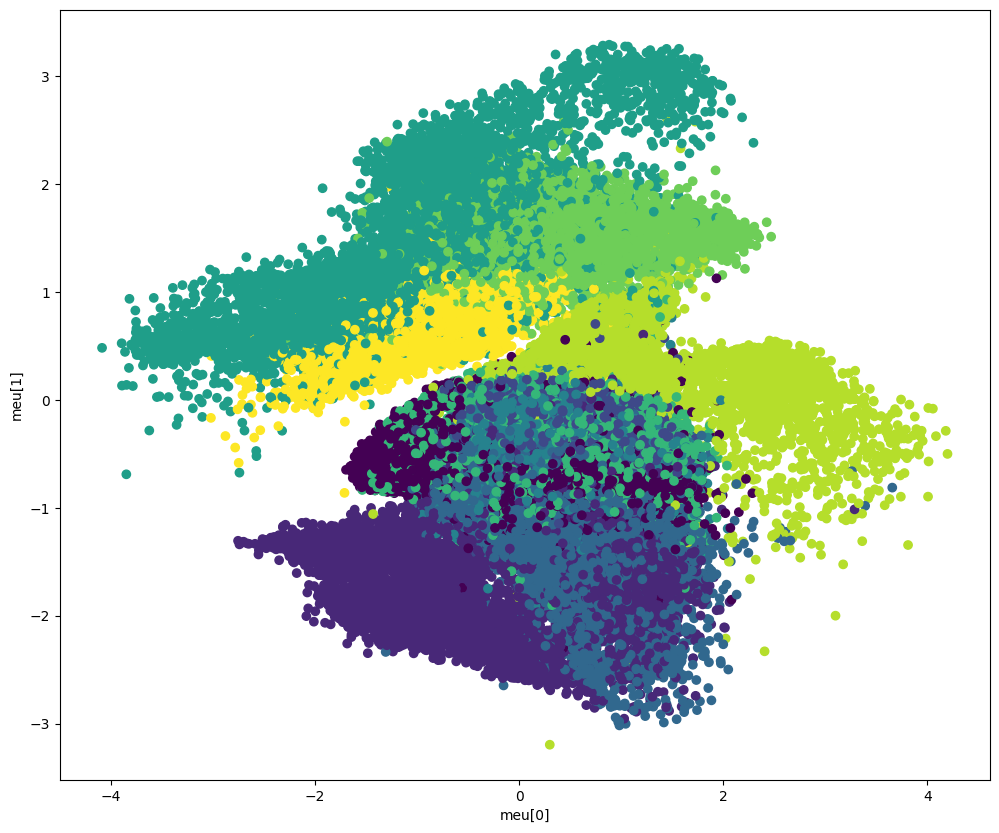

In [126]:
labels = np.concatenate([y_train, y_test], axis = 0)
meu, _, _ = vae.encoder.predict(dataset)
plt.figure(figsize=(12,10))
plt.scatter(meu[:, 0], meu[:, 1], c=labels)
plt.xlabel("meu[0]")
plt.ylabel("meu[1]")
ptl.show();